<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/J-TKim/apple_segmentation/blob/main/apple_segemetation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in google Colab</a>
  </td>
</table>

# Apple Segmentation with OpenCV

## clone dataset from github

In [1]:
!git clone https://github.com/J-TKim/apple_segmentation.git

Cloning into 'apple_segmentation'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


Use Python opencv

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# set image path
image_path = '/content/apple_segmentation/apple2.png'
img = cv2.imread(image_path)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

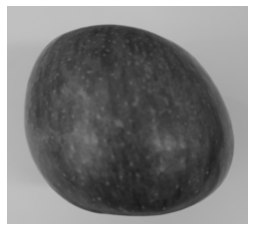

In [3]:
plt.axis("off")
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

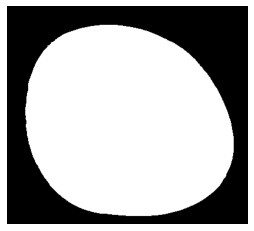

In [4]:
plt.axis("off")
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

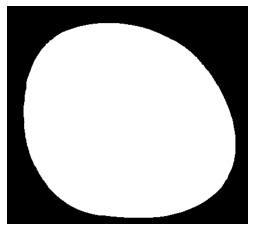

In [6]:
plt.axis("off")
plt.imshow(cv2.cvtColor(sure_bg, cv2.COLOR_BGR2RGB))
plt.show()

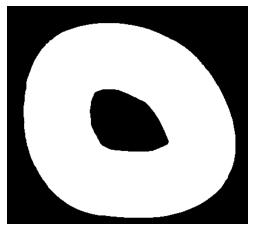

In [7]:
plt.axis("off")
plt.imshow(cv2.cvtColor(unknown, cv2.COLOR_BGR2RGB))
plt.show()

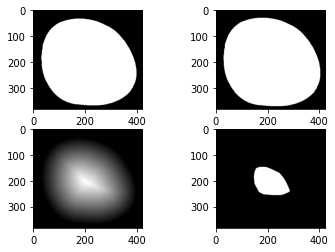

In [8]:
plt.figure()
plt.subplot(221), plt.imshow(opening, cmap='gray')
plt.subplot(222), plt.imshow(sure_bg, cmap='gray')
plt.subplot(223), plt.imshow(dist_transform, cmap='gray')
plt.subplot(224), plt.imshow(sure_fg, cmap='gray')
plt.show()

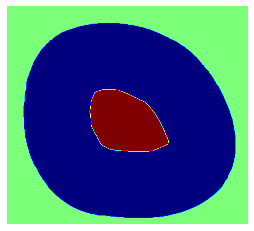

In [9]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers, cmap='jet')
plt.axis('off')
plt.show()

markers :    
>outside == 1   
>line == -1    
>inside == 2   


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb3d8f5aa10>,
 <matplotlib.image.AxesImage at 0x7fb3d8eda4d0>)

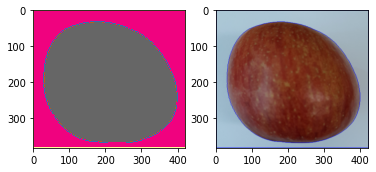

In [10]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

plt.subplot(121), plt.imshow(markers, cmap='Accent')
plt.subplot(122), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

convert sure_bg to np.uint8 type (to findContours)

In [11]:
sure_bg = sure_bg.astype(np.uint8)

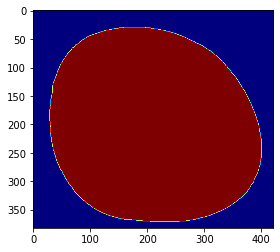

In [12]:
plt.imshow(sure_bg, cmap="jet")

In [13]:
import cv2
import numpy as np

ret, thresh = cv2.threshold(sure_bg, -1, 1, 0)
contours, hierarchy = cv2.findContours(sure_bg, 1, 2)

cnt = contours[0]
M = cv2.moments(cnt)
print(M)

{'m00': 101568.5, 'm10': 21248018.666666664, 'm01': 20749344.833333332, 'm20': 5339972550.583333, 'm11': 4449770475.041666, 'm02': 5009191032.083333, 'm30': 1495561743120.3, 'm21': 1139553330269.6667, 'm12': 1089591727647.1, 'm03': 1335015209552.25, 'mu20': 894910378.1675253, 'mu11': 109030320.96072388, 'mu02': 770324542.8413277, 'mu30': 4016812606.6381836, 'mu21': 3036709047.53244, 'mu12': -2872963752.4191895, 'mu03': -3046209162.4804688, 'nu20': 0.08674839877339491, 'nu11': 0.010568885993320726, 'nu02': 0.07467163445368295, 'nu30': 0.0012217545770030092, 'nu21': 0.0009236460699505562, 'nu12': -0.0008738412661524628, 'nu03': -0.0009265356269342769}


In [14]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

In [15]:
area = cv2.contourArea(cnt)

In [16]:
perimeter = cv2.arcLength(cnt, True)

In [17]:
epsilon = 0.001 * cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

In [18]:
hull = cv2.convexHull(cnt)

In [19]:
k = cv2.isContourConvex(cnt)

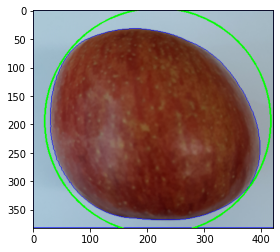

In [20]:
img = cv2.imread(image_path)
img[markers == -1] = [255, 0, 0]

(x, y), radius = cv2.minEnclosingCircle(cnt)
center = (int(x), int(y))
radius = int(radius)
img = cv2.circle(img, center, radius, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), "Accent")
plt.show()